<a id='start'></a>
# Clusterizzazione e Classificazione

In questo notebook vengono presentati degli esercizi sui Decision Tree.

Provate a svolgere il seguente esercizio:<br>
1) [Cluster e elbow method](#section1)<br>
2) [Segmentazione delle specie](#section2)<br>
3) [Crime in Chicago](#section3)<br>

<a id='section1'></a>
## Cluster e elbow method

Proviamo a predere un dataset con tutti i paesi e la loro latitudine e longitudine e a effettuarne una clusterizzazione:

In [1]:
import pandas as pd
data = pd.read_csv('data/Countries-exercise.csv')
data.head()

,name,Longitude,Latitude
0,Aruba,-69.982677,12.520880
1,Afghanistan,66.004734,33.835231
2,Angola,17.537368,-12.293361
3,Anguilla,-63.064989,18.223959
4,Albania,20.049834,41.142450


In [2]:
data.shape

(241, 3)


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


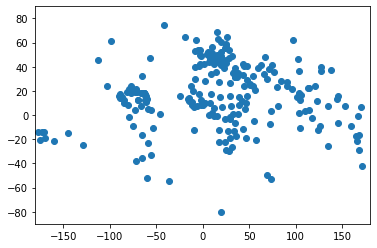

In [3]:
import matplotlib.pyplot as plt

plt.scatter(data['Longitude'], data['Latitude'])
plt.xlim(-180,180)
plt.ylim(-90, 90)
plt.show()

Calcoliamo il numero di cluster da creare con l'elbow method:

Text(0, 0.5, 'Within-cluster Sum of Squares')

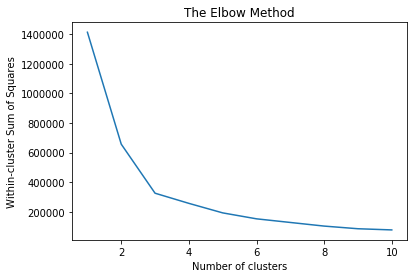

In [4]:
from sklearn.cluster import KMeans

x = data.iloc[:,1:3]
wcss = []
# 'cl_num' is a that keeps track the highest number of clusters we want to use the WCSS method for.
# Note that 'range' doesn't include the upper boundery
cl_num = 11
number_clusters = range(1, cl_num)

for i in number_clusters:
    kmeans = KMeans(i)
    kmeans.fit(x)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    

plt.plot(number_clusters, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')

Il numero ottimale di cluster sembra essere 3, procediamo quindi alla clusterizzazione:

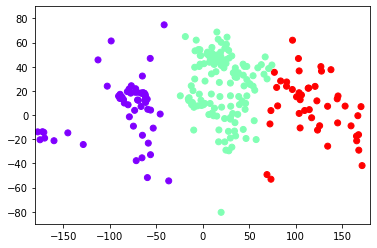

In [5]:
kmeans = KMeans(3)
kmeans.fit(x)

identified_clusters = kmeans.fit_predict(x)
data_with_clusters = data.copy()
data_with_clusters['Cluster'] = identified_clusters

plt.scatter(data['Longitude'], data['Latitude'], c=data_with_clusters['Cluster'], cmap='rainbow')
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.show()

Come si vede, molte isole pacifiche dell'oceania sono catalogate nel cluster insieme alle americhe. Questo avviene perchè nel nostro modello le coordinate non sono considerate come "circolari" e quindi -180 è molto lontano da +179, che invece sappiamo essere vicini.

Per ovviare a questo problema proviamo a fare un meccanismo di "ensamble" unendo diversi modelli, ciascuno con una tralazione delle coordinate di longitudine. Al termine dell'esecuzione di tutti i modelli assegniamo ogni elemento al cluster in cui più frequentemente è stato assegnato.

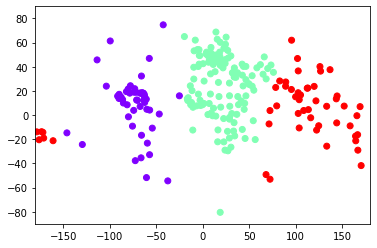

In [7]:
from statistics import mode

# Facciamo un ciclo per calcolare una traslazione delle longitudini tra -180 e +180
computed_vals = []
for t in range(-180, 180):
    kmeans = KMeans(3)
    
    # Trasformo nel dataset le longitudini con la traslazione specificata dall'iterazione
    d = data[['Longitude', 'Latitude']].copy()
    longs = d['Longitude'].values
    longs = [(l + t) % 360 - 180 for l in longs]
    d['Longitude'] = longs
    
    # Calcolo i cluster e recupero i centroidi, con questo metodo cerco di numerare sempre allo stesso modo i
    # cluster creati (partendo da zero in avanti da quello con longitudine minore a quello con longitudine maggiore)
    clusters = kmeans.fit_predict(d)
    centroids_lat = [(x[0] - t) % 360 - 180 for x in kmeans.cluster_centers_]
    centroids_lat_sorted = sorted(centroids_lat)

    centroid_mapping = {}
    for i in range(len(centroids_lat)):
        centroid_mapping[i] = centroids_lat_sorted.index(centroids_lat[i])
        
    # Aggiungo a una mia lista i valori (rinormalizzati) dei cluster stimati
    clusters = list(map(lambda x: centroid_mapping[x], clusters))
    computed_vals.append(clusters)
    
# Calcolo la moda dei cluster computati per ogni elemento nel mio dataset
clusters = []
for i in range(len(data[['Longitude', 'Latitude']].values)):
    vals = [c[i] for c in computed_vals]
    clusters.append(mode(vals))

# Grafico i risultati
plt.scatter(d['Longitude'], d['Latitude'], c=clusters, cmap='rainbow')
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.show()


<a id='section2'></a>
## Segmentazione delle specie

Per questo esercizio utilizzeremo l'Iris flower dataset, che è uno dei dataset più popolari per gli esercizi di machine learning. Puoi leggere molte informazioni a riguardo a questo link: https://en.wikipedia.org/wiki/Iris_flower_data_set

In questo dataset ci sono 4 feature: sepal length, sepal width, petal length, and petal width.

Prova a disegnare i dati con 2, 3 e 5 cluster. Cosa osservi?

Prova a identificare il numero ottimale di cluster e poi calcolalo col metodo elbow.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

data = pd.read_csv('data/iris-dataset.csv')
data.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Visualizziamo i dati:

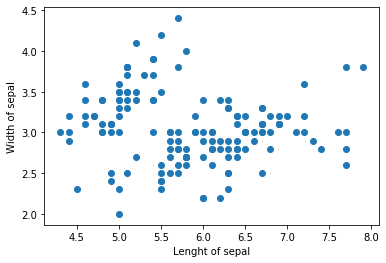

In [4]:
# Create a scatter plot based on two corresponding features (sepal_length and sepal_width; OR petal_length and petal_width)
plt.scatter(data['sepal_length'], data['sepal_width'])
# Name your axes
plt.xlabel('Lenght of sepal')
plt.ylabel('Width of sepal')
plt.show()

Riscaliamo i dati in modo da avere clusterizzazioni più precise:

In [5]:
# import some preprocessing module
from sklearn import preprocessing

# scale the data for better results
x_scaled = preprocessing.scale(data)
x_scaled[:10]

array([[-0.90068117,  1.03205722, -1.3412724 , -1.31297673],
       [-1.14301691, -0.1249576 , -1.3412724 , -1.31297673],
       [-1.38535265,  0.33784833, -1.39813811, -1.31297673],
       [-1.50652052,  0.10644536, -1.2844067 , -1.31297673],
       [-1.02184904,  1.26346019, -1.3412724 , -1.31297673],
       [-0.53717756,  1.95766909, -1.17067529, -1.05003079],
       [-1.50652052,  0.80065426, -1.3412724 , -1.18150376],
       [-1.02184904,  0.80065426, -1.2844067 , -1.31297673],
       [-1.74885626, -0.35636057, -1.3412724 , -1.31297673],
       [-1.14301691,  0.10644536, -1.2844067 , -1.4444497 ]])

Clustering con 2 gruppi:

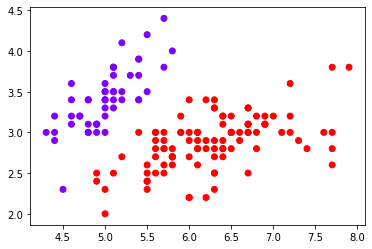

In [6]:
kmeans_2 = KMeans(2)
x = data.copy()
kmeans_2.fit(x_scaled)

# Remember that we are plotting the non-standardized values of the sepal length and width. 
clusters_2 = data.copy()
clusters_2['cluster_pred'] = kmeans_2.fit_predict(x_scaled)
plt.scatter(clusters_2['sepal_length'], clusters_2['sepal_width'], c=clusters_2['cluster_pred'], cmap='rainbow')
plt.show()

Clustering con 3 gruppi:

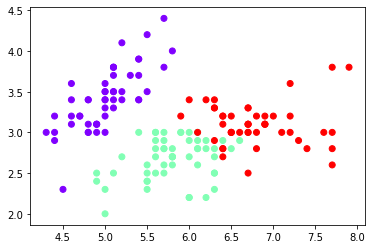

In [7]:
kmeans_3 = KMeans(3)
kmeans_3.fit(x_scaled)

# Remember that we are plotting the non-standardized values of the sepal length and width. 
clusters_3 = data.copy()
clusters_3['cluster_pred'] = kmeans_3.fit_predict(x_scaled)
plt.scatter(clusters_3['sepal_length'], clusters_3['sepal_width'], c=clusters_3['cluster_pred'], cmap='rainbow')
plt.show()

Clustering con 5 gruppi:

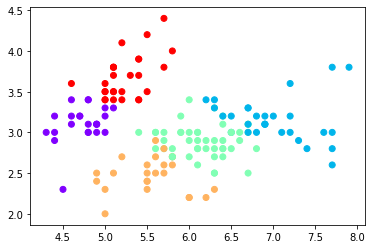

In [8]:
kmeans_5 = KMeans(5)
kmeans_5.fit(x_scaled)

# Remember that we are plotting the non-standardized values of the sepal length and width. 
clusters_5 = data.copy()
clusters_5['cluster_pred'] = kmeans_5.fit_predict(x_scaled)
plt.scatter(clusters_5['sepal_length'], clusters_5['sepal_width'], c=clusters_5['cluster_pred'], cmap='rainbow')
plt.show()

Eseguiamo ora il metodo elbow:

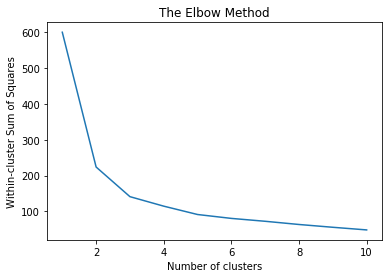

In [9]:
wcss = []
# 'cl_num' is a that keeps track the highest number of clusters we want to use the WCSS method for.
# Note that 'range' doesn't include the upper boundery
cl_num = 11
for i in range (1, cl_num):
    kmeans = KMeans(i)
    kmeans.fit(x_scaled)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    
number_clusters = range(1,cl_num)
plt.plot(number_clusters, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')
plt.show()

Per calcolare il numero di cluster da creare in una clusterizzazione, possiamo usare un metodo detto silhouette.

L'analisi silhouette può essere utilizzata per studiare la distanza di separazione tra i cluster. Il grafico della "sagoma" mostra una misura della vicinanza di ciascun punto in un cluster ai punti dei cluster vicini e fornisce quindi un modo per valutare visivamente i parametri come il numero di cluster. Questa misura ha un intervallo di \[-1, 1\].

I coefficienti silhouette (come vengono chiamati questi valori) vicino a +1 indicano che il campione è lontano dai cluster vicini. Un valore 0 indica che il campione molto vicino al limite di decisione tra due cluster adiacenti e valori negativi indicano che tali campioni potrebbero essere stati assegnati al cluster sbagliato.

For n_clusters = 2 The average silhouette_score is : 0.580184463257396
For n_clusters = 3 The average silhouette_score is : 0.46214947389312017
For n_clusters = 4 The average silhouette_score is : 0.38686030299599405
For n_clusters = 5 The average silhouette_score is : 0.34767483142797456
For n_clusters = 6 The average silhouette_score is : 0.344693092295133


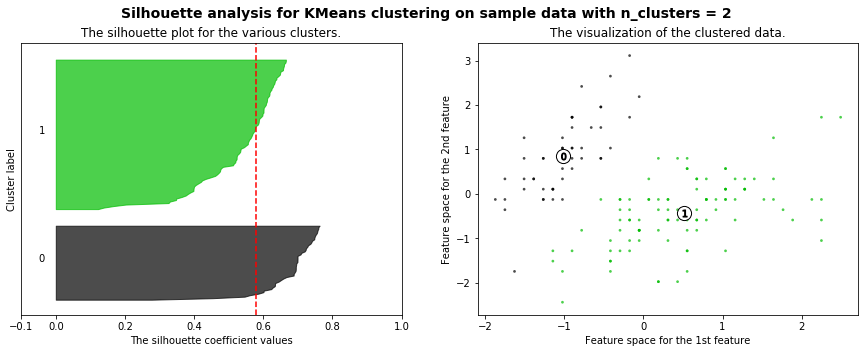

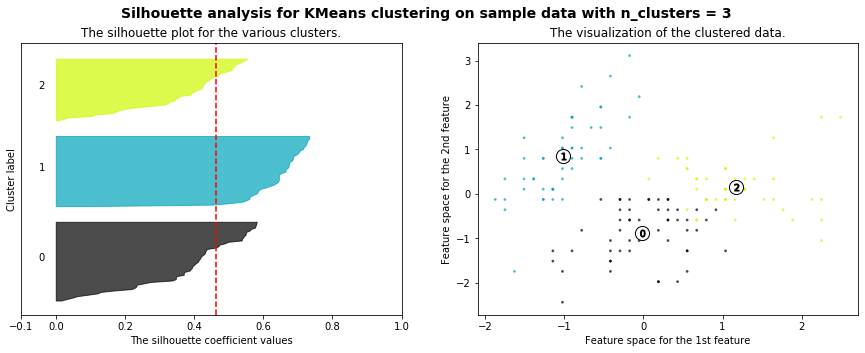

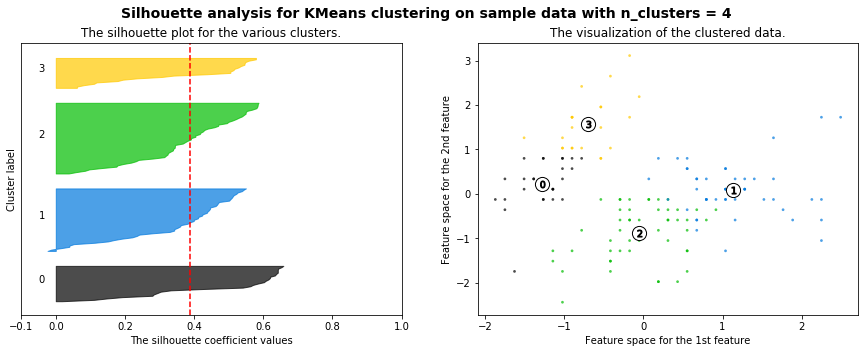

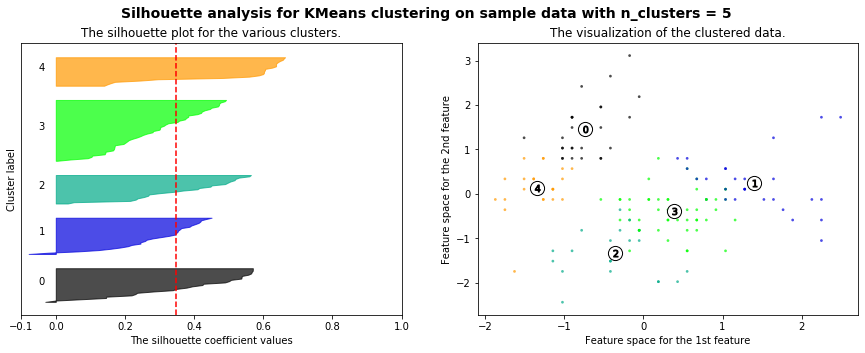

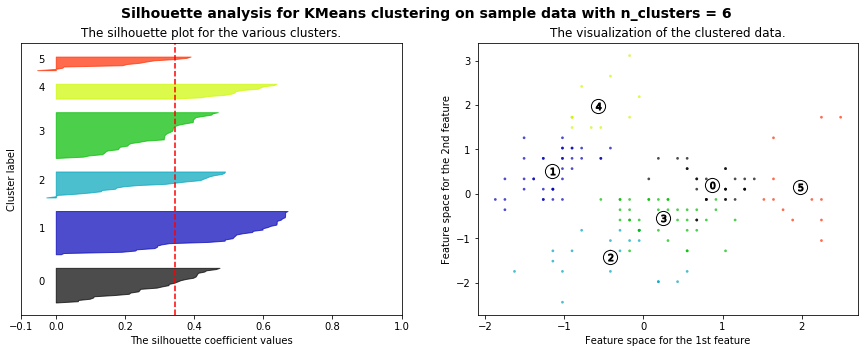

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters)
    cluster_labels = clusterer.fit_predict(x_scaled)
    
    silhouette_avg = silhouette_score(x_scaled, cluster_labels)
    sample_silhouette_values = silhouette_samples(x_scaled, cluster_labels)
    
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(x_scaled) + (n_clusters + 1) * 10])
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x_scaled[:, 0], x_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

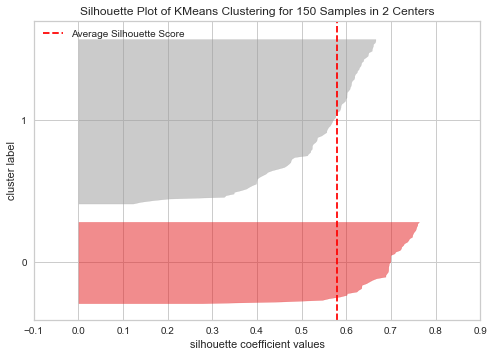

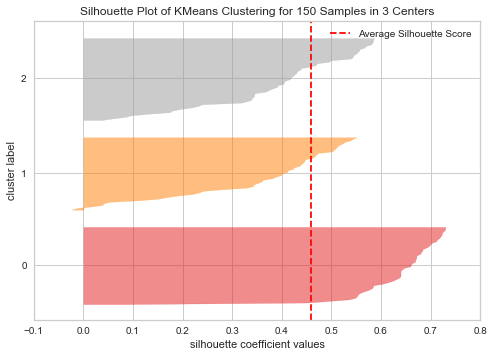

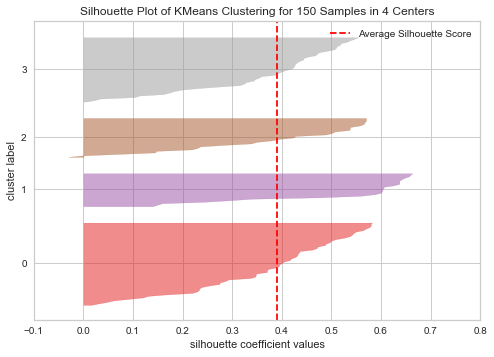

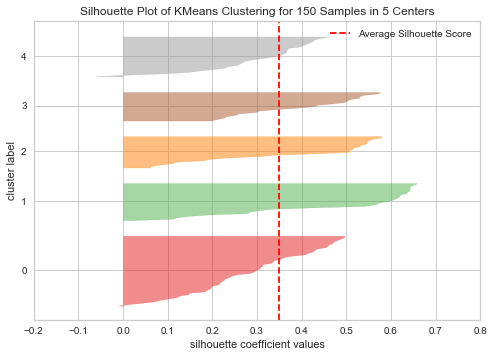

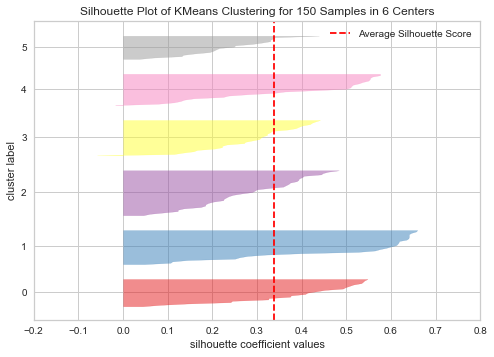

In [20]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:
    model = SilhouetteVisualizer(KMeans(n_clusters))
    model.fit(x_scaled)
    model.show()

Guardando questi grafici (sia visivamente che controllando i valori numerici associati):
- con 2 cluster, la dimensione dei cluster varia (il cluster 0 ha molte più osservazioni del cluster 1).
- con 3 cluster, la dimensione di ogni claster è abbastanza omogenea, quasi nessuna osservazione è assegnata al cluster errato e tutti i cluster hanno osservazioni che sono più della media dello score silhouette.
- con 4, 5 o 6 cluster, i cluster non sono più particolarmente omogenei, più osservazioni hanno valori di silhouette negativi (quindi che indicano essere stati classificati erroneamente)

Questo implica che il metodo Silhouette suggerisce che 3 sia il numero ottimale di cluster da creare.

Il numero di cluster corretto, con entrambi i metodo, quindi sembra essere 3:

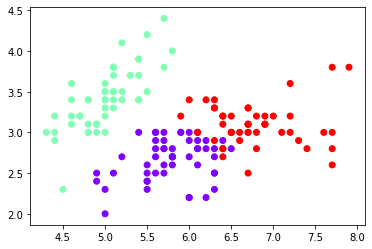

In [18]:
kmeans_3 = KMeans(3)
kmeans_3.fit(x_scaled)

# Remember that we are plotting the non-standardized values of the sepal length and width. 
clusters_3 = data.copy()
clusters_3['cluster_pred'] = kmeans_3.fit_predict(x_scaled)
plt.scatter(clusters_3['sepal_length'], clusters_3['sepal_width'], c=clusters_3['cluster_pred'], cmap='rainbow')
plt.show()

Se proviamo a leggere un altro dataset, che vi fornisco apposta, chiamato iris-with-answers.csv, vedrete che effettivamente 3 è il numero delle specie di iris contenute nel dataset.

In [19]:
real_data = pd.read_csv('data/iris-with-answers.csv')
real_data['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

Il plot di questi dati è molto simile a quello calcolato dal nostro modello e sembra molto confuso:

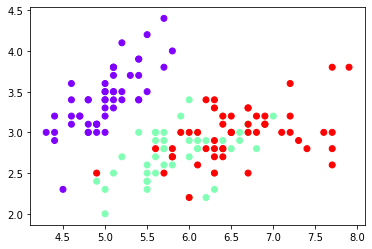

In [20]:
# We use the map function to change any 'yes' values to 1 and 'no'values to 0. 
real_data['species'] = real_data['species'].map({'setosa': 0, 'versicolor': 1 , 'virginica': 2})

plt.scatter(real_data['sepal_length'], real_data['sepal_width'], c=real_data['species'], cmap='rainbow')

Ma se invece che il sepalo, guardassi i petali?

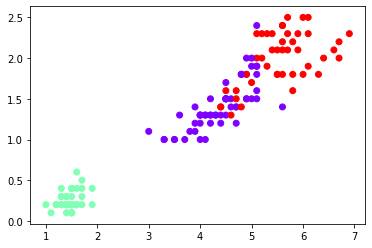

In [21]:
plt.scatter(clusters_3['petal_length'], clusters_3['petal_width'], c=clusters_3['cluster_pred'], cmap='rainbow')

<a id='section3'></a>
## Crime in Chicago

Leggiamo i dati dei crimini accaduti a Chicago con le coordinate di latitudine e longitudine e vediamo come è possibile raggrupparli in diverse categorie in base alla posizione dove i crimini sono avvenuti.

In [22]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.cluster import KMeans

In [23]:
df = pd.read_csv('data/Crimes_-_2001_to_present.csv', header=0)
#Ripuliamo i dati eliminando i dati N/A e formattando i campi data
df = df.dropna(axis=0)
df.Date = pd.to_datetime(df.Date, errors='coerce')
df['Updated On'] = pd.to_datetime(df['Updated On'], errors='coerce')
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10002677,HY191890,2015-03-20 13:13:00,020XX W 70TH ST,1661,GAMBLING,GAME/DICE,STREET,True,False,...,17.0,67.0,19,1164027.0,1858234.0,2015,2018-02-10 15:50:01,41.766615,-87.674337,"(41.766615006, -87.674337321)"
1,10003802,HY193541,2015-03-21 18:45:00,042XX W MONROE ST,1661,GAMBLING,GAME/DICE,SIDEWALK,True,False,...,28.0,26.0,19,1148136.0,1899324.0,2015,2018-02-10 15:50:01,41.879691,-87.731530,"(41.879691121, -87.731529667)"
2,10003937,HY193663,2015-03-21 19:55:00,032XX W LAWRENCE AVE,1670,GAMBLING,GAME/AMUSEMENT DEVICE,SMALL RETAIL STORE,True,False,...,39.0,14.0,19,1154071.0,1931710.0,2015,2018-02-10 15:50:01,41.968445,-87.708871,"(41.968444682, -87.708871059)"
3,10004429,HY194332,2015-03-22 13:57:00,019XX S ST LOUIS AVE,1661,GAMBLING,GAME/DICE,SIDEWALK,True,False,...,24.0,29.0,19,1153407.0,1890195.0,2015,2018-02-10 15:50:01,41.854537,-87.712418,"(41.854537081, -87.71241763)"
4,10005837,HY195964,2015-03-23 20:40:00,039XX W CERMAK RD,1661,GAMBLING,GAME/DICE,PARKING LOT/GARAGE(NON.RESID.),True,False,...,24.0,29.0,19,1150290.0,1889088.0,2015,2018-02-10 15:50:01,41.851561,-87.723887,"(41.851560618, -87.723887245)"


Effettuiamo il metodo elbow sulle location (Longitude e Latitude) dei dati nel dataset:

Text(0, 0.5, 'Within-cluster Sum of Squares')

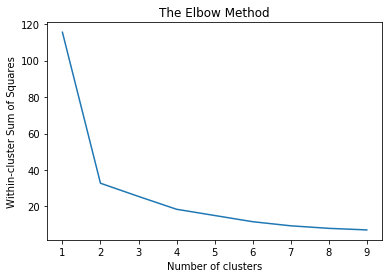

In [24]:
wcss = []

locs = df.loc[:, ['Longitude', 'Latitude']]

cl_num = 10
for i in range (1, cl_num):
    kmeans= KMeans(i)
    kmeans.fit(locs)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    
number_clusters = range(1, cl_num)
plt.plot(number_clusters, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')

Un numero corretto di cluster sembra essere 2:

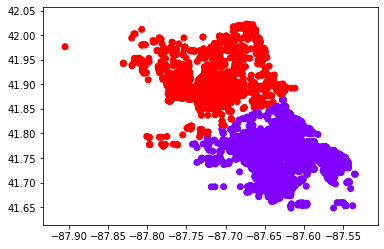

In [25]:
model = KMeans(2)
model.fit(locs)

# Remember that we are plotting the non-standardized values of the sepal length and width. 
df_clustered = locs.copy()
df_clustered['cluster_pred'] = model.fit_predict(df_clustered)
plt.scatter(df.Longitude, df.Latitude, c=df_clustered['cluster_pred'], cmap='rainbow')
plt.show()

Una rappresentazione differente degli stessi dati mostra i centroidi dei vari gruppi:

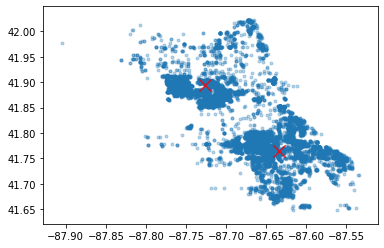

In [26]:
model = KMeans(2)
model.fit(locs)

plt.scatter(df.Longitude, df.Latitude, marker='.', alpha=0.3)

centroids = model.cluster_centers_
plt.scatter(centroids[:,0], centroids[:,1], marker='x', c='red', alpha=0.8, linewidths=3, s=150)

plt.show()

Siccome i cluster sono 2 proviamo a fare una classificazione dei risultati con un grafico:

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

x = df_clustered[['Longitude', 'Latitude']].values
y = df_clustered['cluster_pred']

regr = LogisticRegression(solver='lbfgs')
regr.fit(x, y)

y_pred = regr.predict(x)

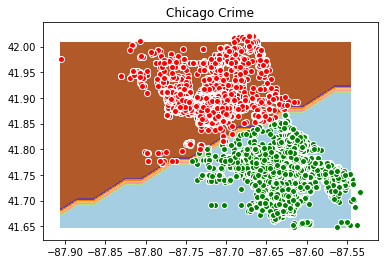

In [28]:
h = .02
x_min, x_max = x[:, 0].min(), x[:, 0].max()
y_min, y_max = x[:, 1].min(), x[:, 1].max()

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

zz = regr.predict(np.c_[xx.ravel(), yy.ravel()])
zz = zz.reshape(xx.shape)
plt.contourf(xx, yy, zz, cmap=plt.cm.Paired)

X_m = x[y_pred==1]
X_b = x[y_pred==0]
plt.title("Chicago Crime")
plt.scatter(X_b[:, 0], X_b[:, 1], c='green',  edgecolor='white')
plt.scatter(X_m[:, 0], X_m[:, 1], c='red',  edgecolor='white')
plt.show()

[Clicca qui per tornare all'inizio della pagina](#start)<a id='start'></a>